<img src="logo.png"/>

# PSF Modelling
In this notebook we will go through the theory of PSF modelling and build a series of functitons to help calculate PSFs in the future.

We have already seen how the PSF of a system can be calculated from the Fourier transform of the apperture function.
However, although this is a good approximation in image processing, in the real world more complicated models are needed. For a correct model of focussing through a high NA lens we must consider the effects of the phase distortions and polarisation of the input light.

The frist step is to redefine the beam as a composition of electrical fields with orthogonal polarisation states. These can then be recombined later to give the final electric field. The next step is to further break up the electric field into an infinite sum of waves travelling towards the focus along vectors $ \textbf{s} =(s_x,s_y,s_z)$. As the electric field is the sum of all of these waves we calculate it by integrating over all possible waves reaching the focus from the exit of the lens. 
 
Without going into the original derivation by Richards and Wolf, the electric field at a point $ \textbf{p} = (x,y,z) $  is calculated using: 

$$ \textbf{E}(x,y,z) = \frac{-ikC}{2\pi} \iint_{\Omega} \textbf{T}(\textbf{s})\exp[ikn(\Phi(s_x,s_y)+s_xx+s_yy+s_zz)] d\Omega$$

As the beam is radially symmetric around the optical axis, this integral is usually taken over the solid angle of the lens, i.e. a double integral over the radial coordinate $\phi $ and the acceptance angle of the lens $\theta$. This results in the coordinate tranform $ \textbf{s} = (s_x,s_y,s_z) = (\sin{\theta}\cos{\phi},\sin{\theta}\sin{\phi},\cos{\theta}
) $ and $ d\Omega = \sin(\theta)d\theta d\phi$

$\textbf{T}(\textbf{s})$ is a matrix drescribing the light at the entrance to the pupil and contains the information on the amplitude, phase and polarisation. We break this term up into these components as:
$$\textbf{T}(\textbf{s}) = \sqrt{\cos{\theta}}A(\theta,\phi)B(\theta,\phi)\begin{bmatrix} p_x\\ p_y\\ p_z \end{bmatrix} $$

Here $A(\theta,\phi)$ describes the amplitude distribution, $B(\theta,\phi)$ describes the phase distribution and $[p_x; p_y; p_z]$ is a matrix describing how the $x,y$ and $z$ polarisation componenets of the light at the lens are rotated as they travel to the focus. The $\sqrt{\cos{\theta}}$ results from the conservation of energy since we are describing a flat field passing through a curved reference sphere. 

<img src="Debeye Integral Co-ordinates.jpg" alt="drawing" width="400"/>
$\textbf{Figure 1}$ Coordinate system for calculating the difraction integral. $\textbf{A}$ is the entrance pupil and $\textbf{B}$ is the reference sphere over which the integral is calculated.

Putting this together we get the rather convoluted formula:

$$ \begin{bmatrix} E_x(x,y,z)\\ E_y(x,y,z)\\ E_z(x,y,z) \end{bmatrix} = \frac{-ikC}{2\pi} \int_{0}^{2\pi} \int_{0}^\alpha \sqrt{\cos{\theta}}A(\theta,\phi)B(\theta,\phi)\begin{bmatrix} p_x\\ p_y\\ p_z \end{bmatrix} \cdots $$ $$ \cdots \times \exp[ikn(x\sin{\theta}\cos{\phi}+y\sin{\theta}\sin{\phi}+z\cos{\theta})]  \sin(\theta) d\theta d\phi $$


To calculate the polarisation at the focus ($[p_x; p_y; p_z]$) we need to define how the polarisation of the light at the pupil ($[P_x; P_y; P_z]$) is transformed through the lens. Again we can skip the derivation which is given in length by Richards and Wolf and define this through a multiplation with a rotation matrix as:

$$\begin{bmatrix} p_x\\ p_y\\ p_z \end{bmatrix} = \begin{bmatrix}
1+(\cos{\theta}-1)\cos^2{\phi} & (\cos{\theta}-1)\cos{\phi}\sin{\phi} & -\sin{\theta}\cos{phi}\\
(\cos{\theta}-1)\cos{\phi}\sin{\phi} & 1+(\cos{\theta}-1)\sin^2{\phi} & -\sin{\theta}\sin{phi}\\ 
\sin{\theta}\cos{\phi} &  -\sin{\theta}\sin{\phi}  & \cos{\theta} \end{bmatrix}\begin{bmatrix} P_x\\ P_y\\ P_z \end{bmatrix} $$

Combining these two equations we can begin to start coding a method to solve this numerically


<function matplotlib.pyplot.show(*args, **kw)>

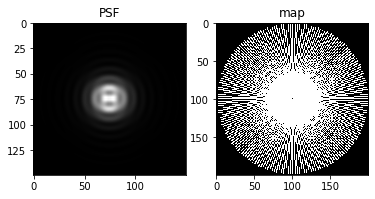

In [17]:
import numpy as np
from matplotlib import pyplot as plt

w = 200 # Number of pixels at the pupil
l = 150 # Number of pixels in the focal plane
wave = 500 # Wavelength (nm)
px = 10 # Pixel size (nm)
NA = 1.49 # Objective numerical aperture 
n = 1.5
Zoff = 0 # z offset

alpha = np.arcsin(NA/n) # Half angle of the objective lens
k = 2*np.pi/wave

dTheta = alpha/w
dPhi = 2*np.pi/w

# Since we're only integrating over the pupil itself, we set A(theta,phi) = 1 everywhere
# we'll keep with the simplest case of no phase mask/ aberrations for the moment ans also set B(theta,phi) = 1 everywhere

# We next initialise the field values in the focal plane
Ex = 0
Ey = 0
Ez = 0

# We now need the relative intensities of the x,z,y components at the pupil plane
Ppupil = np.array([[1],[0],[0]]) # For x-linear 

# We then set up the coordinates in the focal plane
Xs = np.linspace(-l*px,l*px,l)
X,Y = np.meshgrid(Xs,Xs)

# And finally approximate of the integral by calculating the sum over all theta and phi in steps of dTheta and dPhi

from helperFunctions import *

mask = getPhaseMask(w,5,0,0,0)
map = np.zeros([w,w])
C = -1j/wave
for theta in range(0,w):
    t = (theta+1)*dTheta 
        
    for phi in range(0,w):
        p = (phi+1)*dPhi
        
        # Calculate the rotation matrix for theta and phi
        a = 1+(np.cos(t)-1)*np.cos(p)**2
        b = (np.cos(t)-1)*np.cos(p)*np.sin(p)
        c = -np.sin(t)*np.cos(p)
        d = (np.cos(t) -1)*np.cos(p)*np.sin(p)
        e = 1+(np.cos(t)-1)*np.sin(p)**2
        f = -np.sin(t)*np.sin(p)
        
        Prot = np.array([[a,b,c],[d,e,f],[-c,-f,np.cos(t)]])
        
        Pfinal = np.matmul(Prot,Ppupil)
        
        # Our pupil functions:
        A = 1
        Bx = np.int(np.round(w/2+(((w/2-1))*np.sin(t)*np.cos(p))))
        By = np.int(np.round(w/2+(((w/2-1))*np.sin(t)*np.sin(p))))
        B = np.exp(1j*(np.pi+mask[Bx, By]))
        # mask[Bx+w, By+w] = 0
        map[Bx,By] = 1
        # Calculate the contributions to the field
        E = np.sqrt(np.cos(t)) * A * B * np.exp(1j*k*n*(X*np.sin(t)*np.cos(p) + Y*np.sin(t)*np.sin(p) + Zoff*np.cos(t))) * np.sin(t) * dTheta*dPhi
        
        Ex += Pfinal[0]*E
        Ey += Pfinal[1]*E
        Ez += Pfinal[2]*E

Ex = Ex*C
Ey = Ey*C
Ez = Ez*C

PSF = Ex*np.conj(Ex) + Ey*np.conj(Ey) + Ez*np.conj(Ez)
plt.subplot(1,2,1)
plt.imshow(np.abs(PSF),cmap = 'gray')
plt.title('PSF')
plt.subplot(1,2,2)
plt.imshow(map,cmap = 'gray')
plt.title('map')

plt.show